In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import cv2 
import os 
from random import shuffle 
from PIL import Image

In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab/data.csv")
print(df)  
x = df['X']
t = df['T']

       X         T
0   0.51  1.715167
1   1.20  0.352282
2   1.70  0.382885
3   1.81  0.428678
4   1.85  0.446579
..   ...       ...
95  1.88  0.460310
96  0.22  2.584199
97  1.97  0.502564
98  0.38  2.134867
99  1.13  0.395021

[100 rows x 2 columns]


# 1. Sequential Bayesian Learning

1.Plot five curves sampled from the parameter posterior distribution and N data points

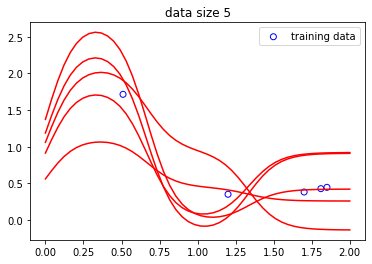

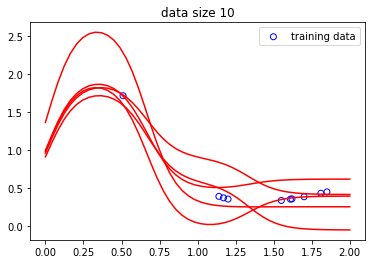

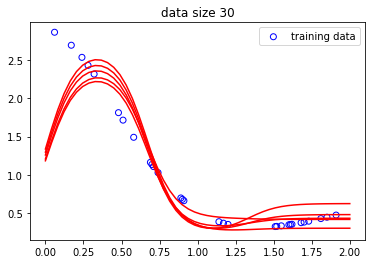

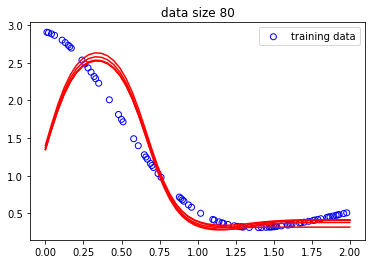

In [4]:
def phi(x, m, trans=1):
    X = []
    for i in range(m):
        X.append(sigmoid(x,i, m))
    if trans:
        return np.array(X).reshape(-1, m)
    else:
        return np.array(X)
def sigmoid(x, j, m, sigma=0.1):
    muj = (2*j)/ m
    a = (x - muj)/ sigma
    return 1/ (1 + np.exp(-a))
def predict(w, x):
    return w.dot(x.T)
def five_curves_sampled():
	M = 3
	s0_inv = (10**-6) * np.identity(M) #S0
	m0 = 0
	beta = 1
	data_len = [5,10,30,80]

	PHI =  phi(x[0], M)
	sn_inv = s0_inv + beta*PHI.T.dot(PHI)
	sn = np.linalg.inv(sn_inv)
	mn = sn.dot(beta*np.dot(PHI.T, t[0]))
	mn = mn.reshape(-1,)
	for i in range(1, x.shape[0]):    
	    if i in data_len:
	        plt.scatter(x[:i],t[:i], facecolor="none", edgecolor="b", label="training data")
	        plt.legend()
	        # sample five curve
	        w_sampled = np.random.multivariate_normal(mn, sn, size=5)
	        sortX = np.linspace(0, 2, 50)
	        pred = predict(w_sampled, phi(sortX, M, 0).T)
	        for j in range(5):
	            plt.title('data size %d' % i)
	            plt.plot(sortX, pred[j], '-r')
	            
	        plt.show()       
	    PHI = np.vstack((PHI, phi(x[i], M)))
	    mn_old = mn
	    sn_inv_old = sn_inv
	    sn_inv = sn_inv + beta*PHI.T.dot(PHI)
	    sn = np.linalg.inv(sn_inv)
	    mn = sn.dot(sn_inv_old.dot(mn)+beta*PHI.T.dot(t[:i+1]).reshape(-1,))

five_curves_sampled()

2.Plot the predictive distribution of target value t by showing the mean curve, the region of
variance with one standard deviation on both sides of the mean curve and N data points

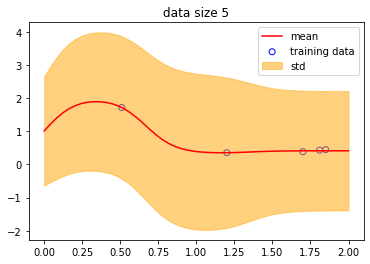

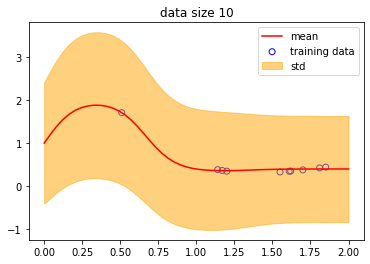

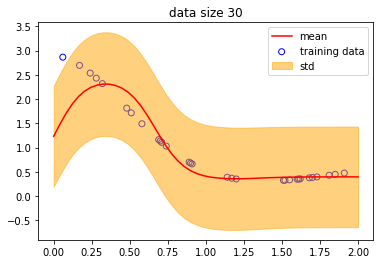

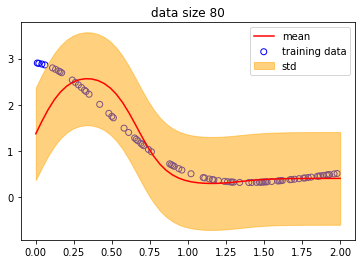

In [5]:
def predictive_dist(x, M, mN, SN, beta=1):
    phiX = phi(x, M, 0).T
    mean = phiX.dot(mN)
    covX = 1/beta + np.sum(phiX.dot(SN).dot(phiX.T), axis=1)
    std = np.sqrt(covX)
    return mean, std
def predictive_distribution():
	M = 3
	s0_inv = (10**-6) * np.identity(M)
	m0 = 0
	beta = 1
	MNs = []
	SNs = []
	data_len = [5,10,30,80]

	PHI =  phi(x[0], M)
	sn_inv = s0_inv + beta*PHI.T.dot(PHI)
	sn = np.linalg.inv(sn_inv)
	mn = sn.dot(beta*np.dot(PHI.T, t[0]))
	mn = mn.reshape(-1,)
	for i in range(1, x.shape[0]):    
	    if i in data_len:
	        sortX = np.linspace(0, 2, 50)
	        mean, std = predictive_dist(sortX, M, mn, sn)
	        plt.title('data size %d' % i)
	        plt.scatter(x[:i],t[:i], facecolor="none", edgecolor="b", label="training data")
	        plt.plot(sortX, mean, 'r', label='mean')
	        plt.fill_between(sortX.reshape(len(sortX)), mean-std, mean+std, alpha=0.5, color='orange', label='std')
	        plt.legend()
	        plt.show()       
	    PHI = np.vstack((PHI, phi(x[i], M)))
	    mn_old = mn
	    sn_inv_old = sn_inv
	    sn_inv = sn_inv + beta*PHI.T.dot(PHI)
	    sn = np.linalg.inv(sn_inv)
	    mn = sn.dot(sn_inv_old.dot(mn)+beta*PHI.T.dot(t[:i+1]).reshape(-1,))

predictive_distribution()

3.Plot the prior distributions by arbitrarily selecting two weights

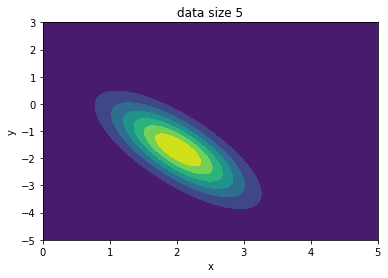

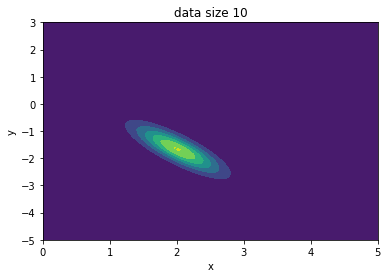

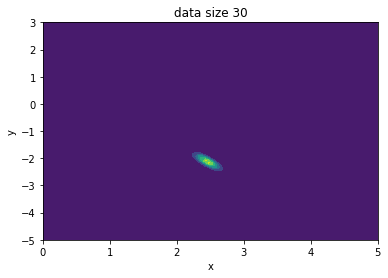

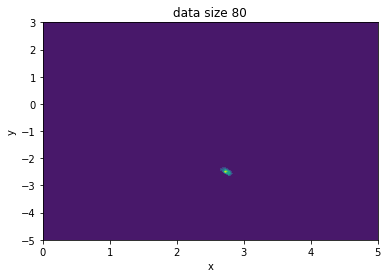

In [6]:
def gaussian(x, mean, sd):
    y = 1 / (2 * np.pi) * 1 / np.sqrt(np.linalg.det(sd)) * np.exp( -0.5 * ((x - mean).T.dot(np.linalg.inv(sd))).dot((x - mean)))
    return y
def prior_distributions():
	M = 3
	s0_inv = (10**-6) * np.identity(M) #S0
	m0 = 0
	beta = 1
	MNs = []
	SNs = []
	data_len = [5,10,30,80]

	PHI =  phi(x[0], M)
	sn_inv = s0_inv + beta*PHI.T.dot(PHI)
	sn = np.linalg.inv(sn_inv)
	mn = sn.dot(beta*np.dot(PHI.T, t[0]))
	mn = mn.reshape(-1,)
	for i in range(1, x.shape[0]):    
		if i in data_len:
			w0, w1 = np.meshgrid(np.linspace(0, 5, 100), np.linspace(-5, 3, 100))
			w_combined = np.array([w0, w1]).transpose(1, 2, 0)
			N_density = np.empty((100, 100))
			for f in range(N_density.shape[0]):
				for g in range(N_density.shape[1]):
					# select weight
					N_density[f, g] = gaussian(w_combined[f, g], mn_old[:2], np.linalg.inv(sn_inv_old)[:2, :2])
			
			plt.title('data size %d' % i)
			plt.xlabel('x')
			plt.ylabel('y')
			plt.contourf(w0[0], w1[:, 0], N_density)
			plt.show()      
		PHI = np.vstack((PHI, phi(x[i], M)))
		mn_old = mn
		sn_inv_old = sn_inv
		sn_inv = sn_inv + beta*PHI.T.dot(PHI)
		sn = np.linalg.inv(sn_inv)
		mn = sn.dot(sn_inv_old.dot(mn)+beta*PHI.T.dot(t[:i+1]).reshape(-1,))

prior_distributions()

# 2 Logistic Regression

In [7]:
np.seterr(all='ignore')
image_size = 16
batch_size = 32

class0 = "/content/gdrive/MyDrive/Colab/Fashion_MNIST/0"
class1 = "/content/gdrive/MyDrive/Colab/Fashion_MNIST/1"
class2 = "/content/gdrive/MyDrive/Colab/Fashion_MNIST/2"
class3 = "/content/gdrive/MyDrive/Colab/Fashion_MNIST/3"
class4 = "/content/gdrive/MyDrive/Colab/Fashion_MNIST/4"

def split_train_test(): #random select 32
  split1 = []
  split2 = []
  split1 = np.random.choice(np.arange(64), 32, replace=False)
  #train.append(total[idx1])
  #split1.extend(idx1)
  split2 = list(set(np.arange(64)) - set(split1))
  #split2.extend(idx2)
  return split1, split2

In [8]:
from tqdm import tqdm
train_data_img = []
test_data_img = []
train_Y = []
test_Y = []
train_class0 = []
train_class1 = []
train_class2 = []
train_class3 = []
train_class4 = []

def load_data():
  for image1 in tqdm(os.listdir(class0)): 
      path = os.path.join(class0, image1)
      img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img1 = cv2.resize(img1, (image_size, image_size))
      train_class0.append(img1)
  a, b = split_train_test()
  for i in a:
    train_data_img.append(train_class0[i])
  for j in b:
    test_data_img.append(train_class0[j])
  for image2 in tqdm(os.listdir(class1)): 
      path = os.path.join(class1, image2)
      img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
      img2 = cv2.resize(img2, (image_size, image_size))
      train_class1.append(img2)
  a, b = split_train_test()
  for i in a:
    train_data_img.append(train_class1[i])
  for j in b:
    test_data_img.append(train_class1[j])

  for image3 in tqdm(os.listdir(class2)): 
      path = os.path.join(class2, image3)
      img3 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
      img3 = cv2.resize(img3, (image_size, image_size))
      train_class2.append(img3)
  a, b = split_train_test()
  for i in a:
    train_data_img.append(train_class2[i])
  for j in b:
    test_data_img.append(train_class2[j])

  for image4 in tqdm(os.listdir(class3)): 
    path = os.path.join(class3, image4)
    img4 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img4 = cv2.resize(img4, (image_size, image_size))
    train_class3.append(img4)
  a, b = split_train_test()
  for i in a:
    train_data_img.append(train_class3[i])
  for j in b:
    test_data_img.append(train_class3[j])

  for image5 in tqdm(os.listdir(class4)): 
    path = os.path.join(class4, image5)
    img5 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img5 = cv2.resize(img5, (image_size, image_size))
    train_class4.append(img5)
  a, b = split_train_test()
  for i in a:
    train_data_img.append(train_class4[i])
  for j in b:
    test_data_img.append(train_class4[j])

  total_data_img = np.concatenate((train_data_img,test_data_img),axis=0)
  return train_data_img, test_data_img, total_data_img

train_data_img, test_data_img, total_data_img = load_data()
print(len(train_data_img),len(test_data_img))

# Normalize
x_train = (train_data_img - np.mean(train_data_img, axis=0)) / (np.std(train_data_img, axis=0) + 1e-100)
x_test = (test_data_img - np.mean(test_data_img, axis=0)) / (np.std(test_data_img, axis=0) + 1e-100)
 
#one-hot label
y_train = np.zeros((160,5))
y_test = np.zeros((160,5))
for j in range(0, 5):
  for i in range(32*j, 32*(j+1)):
    y_train[i, j] = 1
    y_test[i, j] = 1

x_train = x_train.reshape(-1,x_train.shape[1]*x_train.shape[2]) #flatten
x_test = x_test.reshape(-1,x_test.shape[1]*x_test.shape[2]) #flatten

def shuffle(X, Y):
  randomize = np.arange(X.shape[0])
  np.random.shuffle(randomize)
  return (X[randomize], Y[randomize])
 
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
print("x train: ",x_train.shape) #(160,256)
print("x test: ",x_test.shape) #(160,256)
print("y train: ",y_train.shape) #(160,5)
print("y test: ",y_test.shape) #(160,5)

100%|██████████| 64/64 [00:31<00:00,  2.04it/s]

160 160
x train:  (160, 256)
x test:  (160, 256)
y train:  (160, 5)
y test:  (160, 5)


1.
(a)Implement batch GD, SGD, mini-batch
SGD (batch size = 32) and Newton-Raphson algorithms to construct a multiclass logistic
regression (b)Show the classication results of training and test data



1-1 Batch Gradient Descent

epoch:10, train_loss:0.25607096751405395, test_loss:0.3326372482505626

epoch:20, train_loss:0.19775839189661207, test_loss:0.2965685990295994

epoch:30, train_loss:0.1749362572068851, test_loss:0.28454513740716286

epoch:40, train_loss:0.16369361656492887, test_loss:0.2791942484393397

epoch:50, train_loss:0.15762078245659972, test_loss:0.27647859129462543

epoch:60, train_loss:0.1541885882643568, test_loss:0.275000421253844

epoch:70, train_loss:0.15220092508787675, test_loss:0.2741634568863693

epoch:80, train_loss:0.15103385996611482, test_loss:0.27367861194275056

epoch:90, train_loss:0.1503431241886619, test_loss:0.27339395836504343

epoch:100, train_loss:0.14993238720270324, test_loss:0.2732255077155837

train_accuracy:0.9625
test_accuracy:0.9125



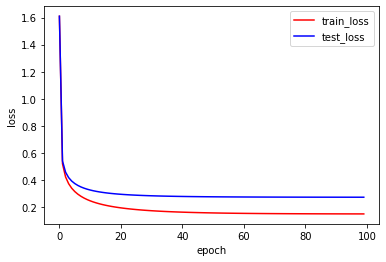

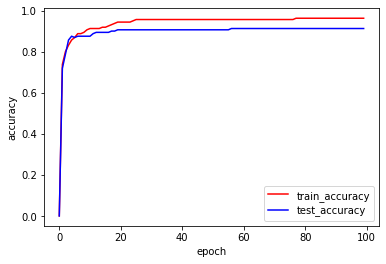

In [9]:
def softmax2(x):
  e = np.exp(x - np.max(x))  # prevent overflow
  if e.ndim == 1:
    return e / np.sum(e, axis=0)
  else:  
    return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2
def cross_entropy(yhat, y ,epsilon=1e-12):
  yhat = np.clip(yhat, epsilon, 1. - epsilon)
  ce = -np.sum(y*np.log(yhat+1e-9))
  return ce

def batch_gradient_descent(train_data,test_data,epoch):
	# initialize
	b = np.zeros(5)
	w = np.ones((train_data.shape[1],5)) #shape: (256,5)
	lr = 1e-3
	epoch = epoch
	epoch_list = []
	train_loss = []
	train_accuracy = []
	test_loss = []
	test_accuracy = []
	m = x_train.shape[0]
	#x_train (160,256) y_train (160,5) pca_feature (160,2)
    
	for e in range(epoch):
		# Calculate the value of error for loss function
		z = np.dot(train_data, w)+b #shape: (160,5)
		yhat = softmax2(z) #shape: (160,5)
		error1 = (1/m) * cross_entropy(yhat,y_train)
		d_y = y_train - yhat
		pred = np.where(yhat>0.5,1,0)
		train_accuracy.append((pred == y_train).all(axis=1).mean())
		lr = lr * 0.95
 
    #test data
		z = np.dot(test_data, w)+b #shape: (160,5)
		yhat = softmax2(z) #shape: (160,5)
		error2 = (1/m) * cross_entropy(yhat,y_test)
		pred = np.where(yhat>0.5,1,0)
		test_accuracy.append((pred == y_test).all(axis=1).mean())
 
		# Calculate the gradient
		w_grad = -np.dot(train_data.T,d_y)  #shape: (256,5)
		b_grad = -np.sum(d_y,axis=0) #shape: (5,)
 
    # Update parameters.
		w = w - lr * w_grad #shape: (256,5)
		b = b - lr * b_grad #shape: (5,)
        
		train_loss.append(error1)
		test_loss.append(error2)
		epoch_list.append(e)
		# Print loss
		if (e+1) % 10 == 0:
			print('epoch:{}, train_loss:{}, test_loss:{}\n'.format(e+1, error1,error2))
	
	print('train_accuracy:{}\ntest_accuracy:{}\n'.format(train_accuracy[e],test_accuracy[e]))
	plt.xlabel("epoch")
	plt.ylabel("loss")
	line1, = plt.plot(epoch_list, train_loss, color = 'red',label = 'train_loss')             
	line2, = plt.plot(epoch_list, test_loss, color = 'blue',label = 'test_loss')
	plt.legend(handles = [line1, line2], loc='upper right')
	plt.show()
	#plt.legend()
	plt.xlabel("epoch")
	plt.ylabel("accuracy")
	line1, = plt.plot(epoch_list, train_accuracy, color = 'red',label = 'train_accuracy')             
	line2, = plt.plot(epoch_list, test_accuracy, color = 'blue',label = 'test_accuracy')
	plt.legend(handles = [line1, line2], loc='lower right')
	plt.show()
 
batch_gradient_descent(x_train,x_test,100)

1-2 Minibatch Gradient Descent (batch size=32)

epoch:10, train_loss:0.5499716046360352, test_loss:0.6940009116147074

epoch:20, train_loss:0.45354262439435505, test_loss:0.6087026728276426

epoch:30, train_loss:0.4288007102095606, test_loss:0.5864946752605362

epoch:40, train_loss:0.42092706367147953, test_loss:0.5794051301345176

epoch:50, train_loss:0.41826386170868457, test_loss:0.5770048980565325

epoch:60, train_loss:0.4173448947335289, test_loss:0.5761764156131205

epoch:70, train_loss:0.4170256275407606, test_loss:0.5758885540776968

epoch:80, train_loss:0.4169144459844322, test_loss:0.5757883055494524

epoch:90, train_loss:0.4168756963716298, test_loss:0.5757533659309046

epoch:100, train_loss:0.41686218728265845, test_loss:0.5757411850476032

train_accuracy:0.84375
test_accuracy:0.8125



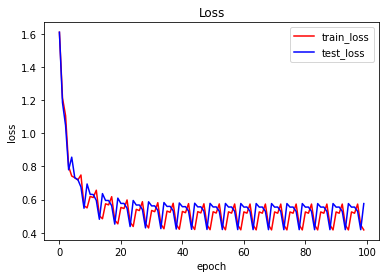

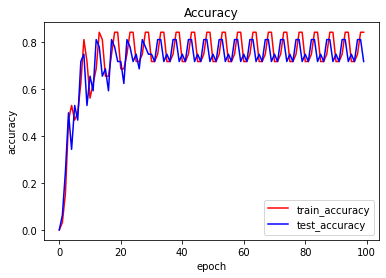

In [10]:
def minibatch_gradient_descent(train_data,test_data,epoch):
  # initialize
  batch_size = 32
  b = np.zeros(5)
  w = np.ones((train_data.shape[1],5)) #shape: (32,5)
  lr = 1e-3
  epoch = epoch
  test_best = 0
  train_best = 0
  epoch_list = []
  train_loss = []
  train_accuracy = []
  test_loss = []
  test_accuracy = []
  minibatch_x = []
  minibatch_y = []
  minibatch_test_x = []
  minibatch_test_y = []
  #x_train (160,256) y_train (160,5)
  for e in range(epoch):
    # Calculate the value of error for loss function
    index = (32*(e%5))
    minibatch_x = train_data[index:index+32] #shape: (32,256)
    minibatch_y = y_train[index:index+32] #shape: (32,5)
    #print("minibatch_x.shape: ",minibatch_x.shape,"minibatch_y.shape: ",minibatch_y.shape)
    z = np.dot(minibatch_x,w)+b #shape: (1,5)
    yhat = softmax2(z) #shape: (1,5)
    error1 = (1/32) * cross_entropy(yhat,minibatch_y)
    d_y = minibatch_y - yhat
    pred = np.where(yhat>0.5,1,0)
    train_accuracy.append((pred == minibatch_y).all(axis=1).mean())
    lr = lr * 0.9

    #test data
    minibatch_test_x = test_data[index:index+32] #shape: (32,256)
    minibatch_test_y = y_test[index:index+32] #shape: (32,5)
    z = np.dot(minibatch_test_x, w)+b #shape: (160,5)
    yhat = softmax2(z) #shape: (160,5)
    error2 = (1/32) * cross_entropy(yhat,minibatch_test_y)
    pred = np.where(yhat>0.5,1,0)
    test_accuracy.append((pred == minibatch_test_y).all(axis=1).mean())
   
    # Calculate the gradient
    w_grad = -np.dot(minibatch_x.T,d_y)  #shape: (256,5)
    b_grad = -np.sum(d_y,axis=0) #shape: (5,)
   
    # Update parameters.
    w = w - lr * w_grad #shape: (256,5)
    b = b - lr * b_grad #shape: (5,)

    train_loss.append(error1)
    test_loss.append(error2)
    epoch_list.append(e)

    if train_accuracy[e] > train_best:
      train_best = train_accuracy[e]
    if test_accuracy[e] > test_best:
      test_best = test_accuracy[e]

    # Print loss
    if (e+1) % 10 == 0:
      print('epoch:{}, train_loss:{}, test_loss:{}\n'.format(e+1, error1,error2))
      #print('train_accuracy:{}\ntest_accuracy:{}\n'.format(train_accuracy[e],test_accuracy[e]))

  print('train_accuracy:{}\ntest_accuracy:{}\n'.format(train_best,test_best))
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Loss")
  line1, = plt.plot(epoch_list, train_loss, color = 'red',label = 'train_loss')             
  line2, = plt.plot(epoch_list, test_loss, color = 'blue',label = 'test_loss')
  plt.legend(handles = [line1, line2], loc='upper right')
  plt.show()
  #plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy")
  line1, = plt.plot(epoch_list, train_accuracy, color = 'red',label = 'train_accuracy')             
  line2, = plt.plot(epoch_list, test_accuracy, color = 'blue',label = 'test_accuracy')
  plt.legend(handles = [line1, line2], loc='lower right')
  plt.show()

minibatch_gradient_descent(x_train,x_test,100)

1-3 Stochastic Gradient Descent

epoch:10, Train_Loss:1.46682863857835, Test_Loss:1.5371603437288244

epoch:20, Train_Loss:1.1201909797823877, Test_Loss:1.5358906531682355

epoch:30, Train_Loss:1.280931554946224, Test_Loss:1.1409524474268877

epoch:40, Train_Loss:1.4003503498156677, Test_Loss:1.5475976074800857

epoch:50, Train_Loss:1.3243646156728637, Test_Loss:1.255180101419423

epoch:60, Train_Loss:1.5772616495816365, Test_Loss:1.2152829728217

epoch:70, Train_Loss:1.0412518963234003, Test_Loss:1.3957282285730848

epoch:80, Train_Loss:1.5750511386065655, Test_Loss:1.1457184889462086

epoch:90, Train_Loss:0.9842743241863743, Test_Loss:1.4657558004291478

epoch:100, Train_Loss:1.040401989732963, Test_Loss:1.373839391595479

train_accuracy:0.2
test_accuracy:1.0



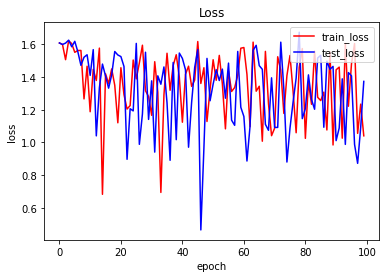

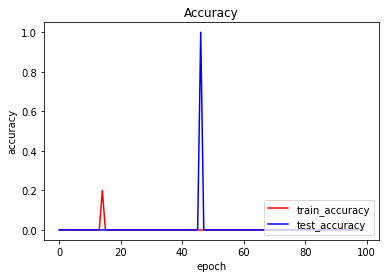

In [11]:
import random
def stochastic_gradient_descent(train_data,test_data,epoch):
	# initialize
	b = np.zeros(5)
	w = np.zeros((train_data.shape[1],5)) #shape: (256,5)
	lr = 1e-3
	epoch = epoch
	train_best = 0
	test_best = 0
	epoch_list = []
	train_loss = []
	train_accuracy = []
	test_loss = []
	test_accuracy = []
	m = train_data.shape[0] 
	for e in range(epoch):
		# Calculate the value of error for loss function
		random_index = random.randint(0,train_data.shape[0]-1) # random index from total samples
		#print("random_index: ",random_index)
		sample_x = train_data[random_index].reshape(1,-1) #shape: (1,256)
		sample_y = y_train[random_index].reshape(1,-1) #shape: (1,5)
		z = np.dot(sample_x,w)+b #shape: (1,5)
		yhat = softmax2(z) #shape: (1,5)
		error1 = cross_entropy(yhat,sample_y)
		d_y = sample_y - yhat
		#print(sample_y,yhat,d_y)
		pred = np.where(yhat>0.5,1,0)
		train_accuracy.append((pred == y_train).all(axis=1).mean())
		# print("sample_y.shape: ",sample_y.shape,"yhat: ",yhat.shape,"d_y: ",d_y.shape)
		lr = lr * 0.95  
		#test data
		sample_test_x = test_data[random_index].reshape(1,-1) #shape: (1,256)
		sample_test_y = y_test[random_index].reshape(1,-1) #shape: (1,5)
		z = np.dot(sample_test_x, w)+b #shape: (160,5)
		yhat = softmax2(z) #shape: (160,5)
		error2 = cross_entropy(yhat,sample_test_y)
		pred = np.where(yhat>0.5,1,0)
		test_accuracy.append((pred == sample_test_y).all(axis=1).mean())  
		# Calculate the gradient
		w_grad = -np.dot(sample_x.T,d_y) #shape: (256,5)
		b_grad = -np.sum(d_y,axis=0)  
		# Update parameters.
		w = w - lr * w_grad #shape: (256,5)
		b = b - lr * b_grad 
		train_loss.append(error1)
		test_loss.append(error2)
		epoch_list.append(e)
		if train_accuracy[e] > train_best:
			train_best = train_accuracy[e]
		if test_accuracy[e] > test_best:
			test_best = test_accuracy[e]
		# Print loss
		if (e+1) % 10 == 0:
			print('epoch:{}, Train_Loss:{}, Test_Loss:{}\n'.format(e+1, error1,error2))

	print('train_accuracy:{}\ntest_accuracy:{}\n'.format(train_best,test_best))	
	plt.xlabel("epoch")
	plt.ylabel("loss")
	plt.title("Loss")
	line1, = plt.plot(epoch_list, train_loss, color = 'red',label = 'train_loss')             
	line2, = plt.plot(epoch_list, test_loss, color = 'blue',label = 'test_loss')
	plt.legend(handles = [line1, line2], loc='upper right')
	plt.show()
	#plt.legend()
	plt.xlabel("epoch")
	plt.ylabel("accuracy")
	plt.title("Accuracy")
	line1, = plt.plot(epoch_list, train_accuracy, color = 'red',label = 'train_accuracy')             
	line2, = plt.plot(epoch_list, test_accuracy, color = 'blue',label = 'test_accuracy')
	plt.legend(handles = [line1, line2], loc='lower right')
	plt.show()

stochastic_gradient_descent(x_train,x_test,100)

1-4 Newton Raphson

In [12]:
def hessian(x,yhat):
	# x.T * np.diag(d_y*(h1-d_y)) * x
	hes = np.zeros((256,256))
	for i in range(256):
		for j in range(256):
			hes[i][j] = 1e-35

	out=[]
	a = np.multiply(yhat,(1-yhat)) #(160,5)
	a = np.diag(a) #(5,)
  #hes += np.dot(np.dot(x.T,a),x)
	for i in range(5):
		out.append(np.dot(np.dot(x.T,a[i]),x))
	return hes+out

def newton_raphson(train_data,test_data,epoch):
	# initialize
	b = np.zeros(5)
	w = np.zeros((train_data.shape[1],5)) #shape: (256,5)
	lr = 1e-3
	epoch = epoch
	epoch_list = []
	train_loss = []
	train_accuracy = []
	test_loss = []
	test_accuracy = []
	m = x_train.shape[0]
	train_best = 0
	test_best = 0
	beta = np.matrix((np.zeros(x_train.shape[1]),5)).T

	for e in range(epoch):
		z = np.dot(train_data, w)+b #shape: (160,5)
		yhat = softmax2(z) #shape: (160,5)
		error1 = (1/m) * cross_entropy(yhat,y_train)
		d_y = y_train - yhat
		pred = np.where(yhat>0.5,1,0)
		train_accuracy.append((pred == y_train).all(axis=1).mean())
		lr = lr*0.9
		w_grad = -np.dot(train_data.T,d_y)  #shape: (256,5)
		b_grad = -np.sum(d_y,axis=0) #shape: (5,)
		w = w - lr * w_grad
		
		c = hessian(train_data,yhat)
		
    #test data
		z = np.dot(test_data, w)+b #shape: (160,5)
		yhat = softmax2(z) #shape: (160,5)
		error2 = (1/m) * cross_entropy(yhat,y_test)
		pred = np.where(yhat>0.5,1,0)
		test_accuracy.append((pred == y_test).all(axis=1).mean())

		# Update parameters
		w = w - np.linalg.inv(c) * w_grad
		b = b - lr * b_grad

		train_loss.append(error1)
		test_loss.append(error2)
		epoch_list.append(e)
		if train_accuracy[e] > train_best:
			train_best = train_accuracy[e]
		if test_accuracy[e] > test_best:
			test_best = test_accuracy[e]
		# Print loss
		if (e+1) % 10 == 0:
			print('epoch:{}, Train_Loss:{}, Test_Loss:{}\n'.format(e+1, error1,error2))

	print('train_accuracy:{}\ntest_accuracy:{}\n'.format(train_best,test_best))
	plt.xlabel("epoch")
	plt.ylabel("loss")
	line1, = plt.plot(epoch_list, train_loss, color = 'red',label = 'train_loss')             
	line2, = plt.plot(epoch_list, test_loss, color = 'blue',label = 'test_loss')
	plt.legend(handles = [line1, line2], loc='upper right')
	plt.show()
	plt.xlabel("epoch")
	plt.ylabel("accuracy")
	line1, = plt.plot(epoch_list, train_accuracy, color = 'red',label = 'train_accuracy')             
	line2, = plt.plot(epoch_list, test_accuracy, color = 'blue',label = 'test_accuracy')
	plt.legend(handles = [line1, line2], loc='lower right')
	plt.show()
 
newton_raphson(x_train,x_test,100)

ValueError: ignored

2.Use principal component analysis (PCA) to reduce the dimension of images to d = 2,5,10.

2-1.Repeat 1 by using PCA to reduce the dimension of images to d.

In [13]:
def SVD(u, v, u_based_decision=True):
  #https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py#L500
  # columns of u, rows of v
  max_abs_cols = np.argmax(np.abs(u), axis=0)
  signs = np.sign(u[max_abs_cols, range(u.shape[1])])
  u *= signs
  v *= signs[:, np.newaxis]
  return u, v

def PCA(features, n, svd, mean=1, test=0):
  M = np.mean(features.T, axis=1)
  C = features - M # center column
  mean=1
  # eigendecomposition
  u, d, v = np.linalg.svd(C, full_matrices=False)
  u, v = SVD(u, v)
  Trans_comp = np.dot(features.T, u[:, :n])
  s = np.diag(d)
  Trans = u[:, :n].dot(s[:n, :n])
  return Trans, Trans_comp.T

BGD

epoch:10, train_loss:0.7438619288418102, test_loss:0.8355494007913923

train_accuracy:0.5875
test_accuracy:0.5625



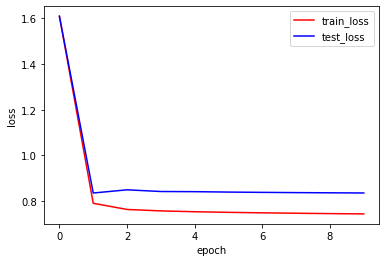

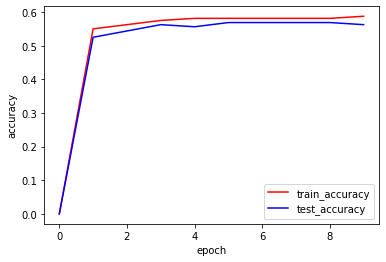

epoch:10, train_loss:0.4350681118062225, test_loss:0.64401780378525

train_accuracy:0.825
test_accuracy:0.725



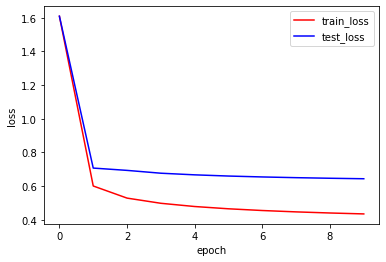

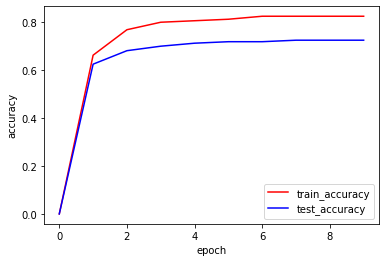

epoch:10, train_loss:0.31789306938349193, test_loss:0.6999158720042337

train_accuracy:0.875
test_accuracy:0.6625



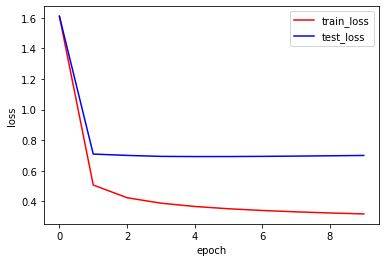

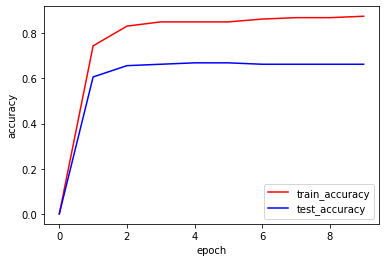

In [ ]:
d=[2,5,10]
for i in range(3):
  pca_train, pca_com = PCA(x_train, d[i], 1)
  pca_test, pca_com = PCA(x_test, d[i], 1)
  batch_gradient_descent(pca_train,pca_test,10)

minibatch GD

epoch:10, train_loss:0.8341603715996877, test_loss:0.9785519300217581

epoch:20, train_loss:0.792447016085345, test_loss:0.9455428293869745

epoch:30, train_loss:0.783124641193343, test_loss:0.9379092011571852

epoch:40, train_loss:0.7802846198811327, test_loss:0.9355496622140652

train_accuracy:0.625
test_accuracy:0.59375



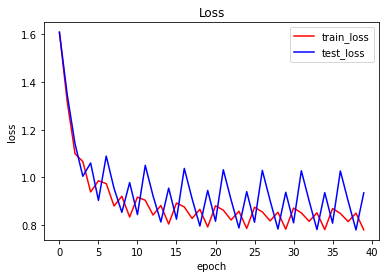

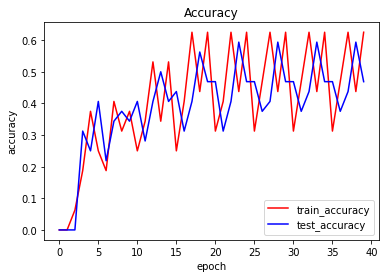

epoch:10, train_loss:0.6433955647463035, test_loss:0.9157549816265448

epoch:20, train_loss:0.5745297100461397, test_loss:0.8824602061710933

epoch:30, train_loss:0.5572017022177058, test_loss:0.8751450755091803

epoch:40, train_loss:0.5517022498246311, test_loss:0.8729306970074177

train_accuracy:0.8125
test_accuracy:0.78125



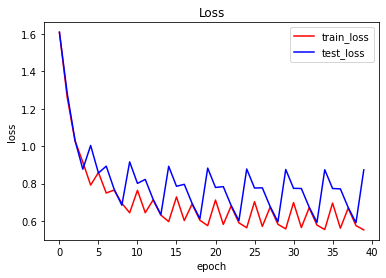

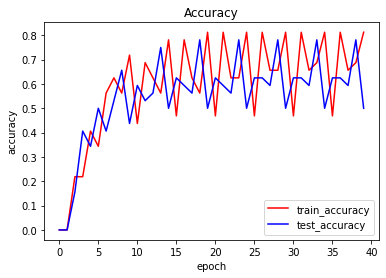

epoch:10, train_loss:0.5430557315493258, test_loss:0.9338597514005358

epoch:20, train_loss:0.46466538098795646, test_loss:0.9096576624479791

epoch:30, train_loss:0.4450963097730749, test_loss:0.9052190253098957

epoch:40, train_loss:0.43890906341821356, test_loss:0.9039768269061275

train_accuracy:0.875
test_accuracy:0.71875



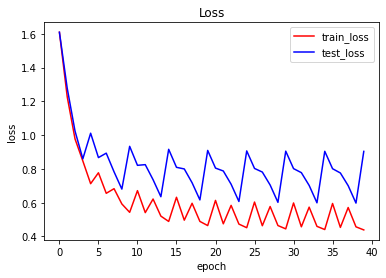

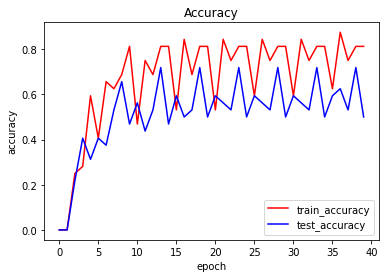

In [ ]:
d=[2,5,10]
for i in range(3):
  pca_train, pca_com = PCA(x_train, d[i], 1)
  pca_test, pca_com = PCA(x_test, d[i], 1)
  minibatch_gradient_descent(pca_train,pca_test,40)

SGD

epoch:10, Train_Loss:1.4898484710609294, Test_Loss:1.6552368297524684

epoch:20, Train_Loss:1.426198803865602, Test_Loss:1.7009944646405235

epoch:30, Train_Loss:1.4670551799336602, Test_Loss:1.5749692811625096

epoch:40, Train_Loss:1.4677886126426387, Test_Loss:1.6957129127333308

train_accuracy:0
test_accuracy:0



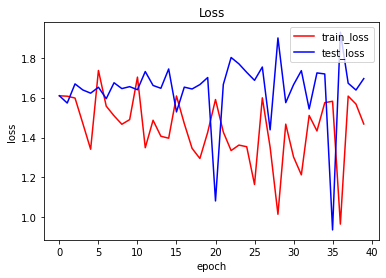

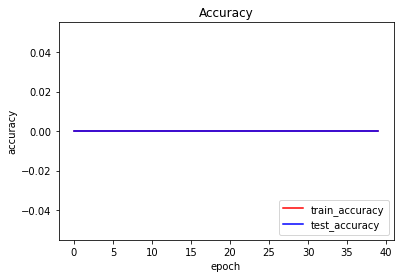

epoch:10, Train_Loss:1.261226299044338, Test_Loss:1.7535883923164064

epoch:20, Train_Loss:1.531583030547335, Test_Loss:1.6069292490800025

epoch:30, Train_Loss:1.0844447027554487, Test_Loss:1.8510447685753626

epoch:40, Train_Loss:1.5281334364303838, Test_Loss:1.761838842973018

train_accuracy:0
test_accuracy:0



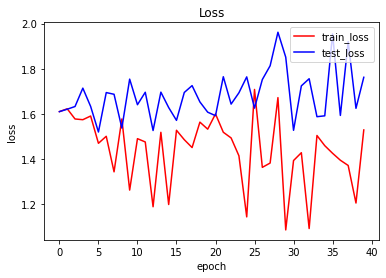

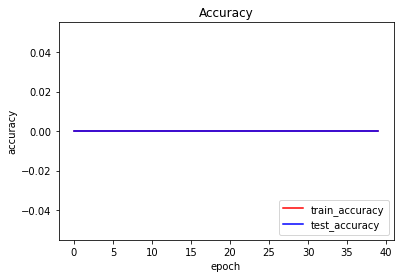

epoch:10, Train_Loss:1.5840651250005093, Test_Loss:1.5978927485374972

epoch:20, Train_Loss:1.5148417469546211, Test_Loss:1.5850435239878229

epoch:30, Train_Loss:1.2327659108301907, Test_Loss:1.6122224815871469

epoch:40, Train_Loss:1.495996371656421, Test_Loss:1.9131618433053479

train_accuracy:0
test_accuracy:0



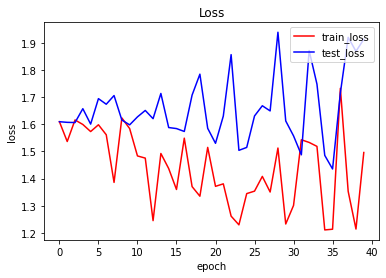

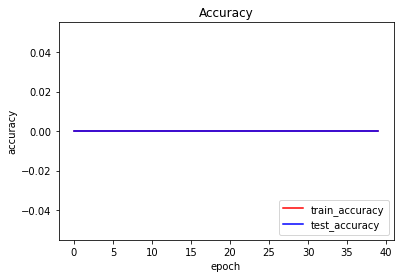

In [14]:
d=[2,5,10]
for i in range(3):
  pca_train, pca_com = PCA(x_train, d[i], 1)
  pca_test, pca_com = PCA(x_test, d[i], 1)
  stochastic_gradient_descent(pca_train,pca_test,40)

2-2.Plot d eigenvectors corresponding to top d eigenvalues

d=2

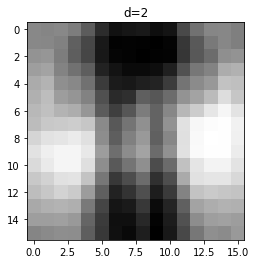

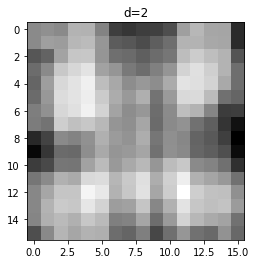

In [ ]:
pca_feature, pca_com = PCA(x_train, 2, 1)
for i in range(2):
  plt.imshow(pca_com[i].reshape(16, 16), cmap='gray')
  plt.xticks()
  plt.yticks()
  plt.title("d=2")
  plt.show()

d=5

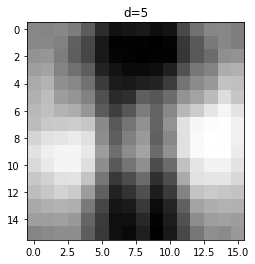

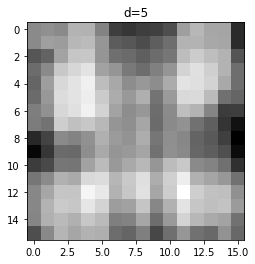

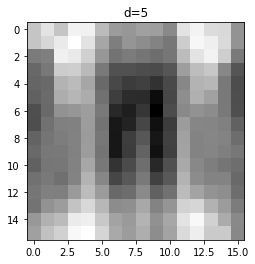

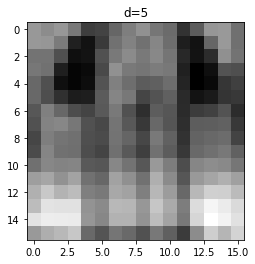

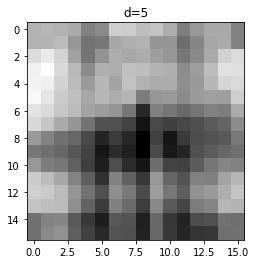

In [ ]:
pca_feature, pca_com = PCA(x_train, 5, 1)
for i in range(5):
  plt.imshow(pca_com[i].reshape(16, 16), cmap='gray')
  plt.xticks()
  plt.yticks()
  plt.title("d=5")
  plt.show()

d=10

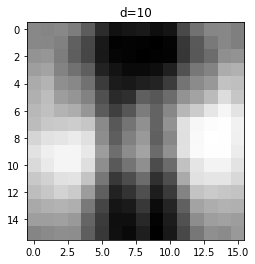

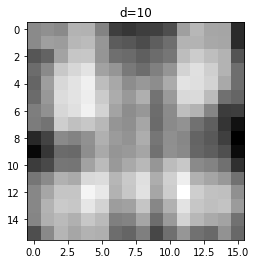

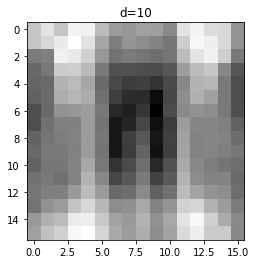

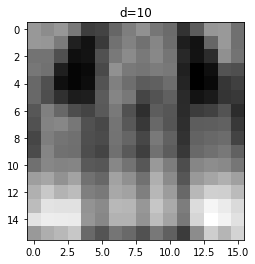

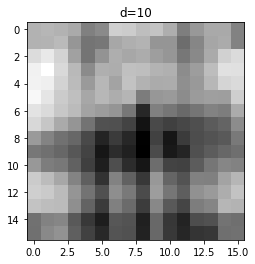

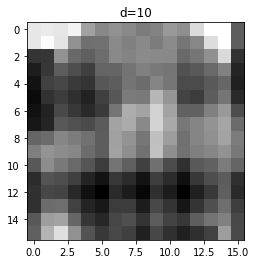

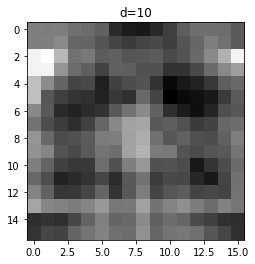

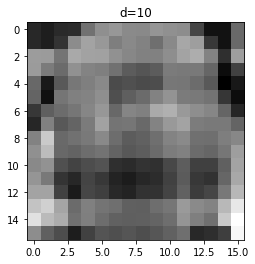

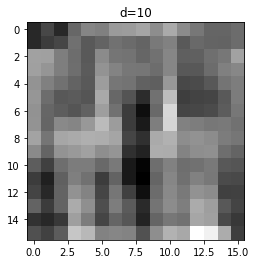

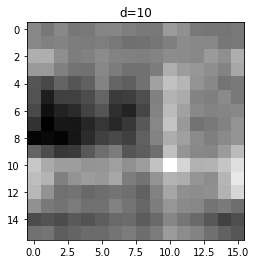

In [ ]:
pca_feature, pca_com = PCA(x_train, 10, 1)
for i in range(10):
  plt.imshow(pca_com[i].reshape(16, 16), cmap='gray')
  plt.xticks()
  plt.yticks()
  plt.title("d=10")
  plt.show()

3.What do the decision regions and data points look like on the vector space

3-1.Plot the decision regions and data points of the images on the span of top 2 eigenvectors by using PCA to reduce the dimension of images to 2.

IndexError: ignored

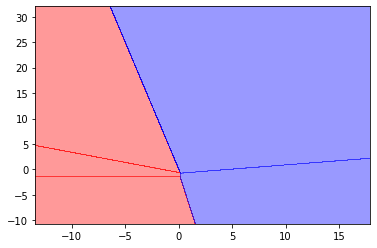

In [50]:
from matplotlib.colors import ListedColormap

def predict123(X):
  w,b = bgd(pca_train,y_combined,100)
  zz = np.dot(X, w)+b
  #print(np.argmax(zz, axis=1))
  return np.argmax(zz, axis=1)
def bgd(train_data,y_combined,epoch):
  # initialize
  b = np.zeros(5)
  w = np.ones((train_data.shape[1],5)) #shape: (256,5)
  lr = 1e-3
  epoch = epoch
  m = train_data.shape[0]
  for e in range(epoch):
    # Calculate the value of error for loss function
    z = np.dot(train_data, w)+b #shape: (320,5)
    yhat = softmax2(z) #shape: (160,5)
    error1 = (1/m) * cross_entropy(yhat,yclass)
    d_y = y_combined - yhat
    lr = lr * 0.95
    # Calculate the gradient
    w_grad = -np.dot(train_data.T,d_y)  #shape: (256,5)
    b_grad = -np.sum(d_y,axis=0) #shape: (5,)
    # Update parameters.
    w = w - lr * w_grad #shape: (256,5)
    b = b - lr * b_grad #shape: (5,)
  return w,b

def plot_decision_regions(X, y, test_idx=None, resolution=0.02):
  # setup marker generator and color map
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # plot the decision surface
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
  #print(np.array([xx1.ravel(), xx2.ravel()]).T.shape)

  #Z = np.dot((np.array([xx1.ravel(), xx2.ravel()]).T),np.array(weights[0])) + weights[1]
  Z = predict123((np.array([xx1.ravel(), xx2.ravel()]).T))
  Z = Z.reshape(xx1.shape)
  #weights
  plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap(idx),marker=markers[idx], label=cl)
  # highlight test samples
  if test_idx:
    # plot all samples
    if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
      X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
      warnings.warn('Please update to NumPy 1.9.0 or newer')
    else:
      X_test, y_test = X[test_idx, :], y[test_idx]

    plt.scatter(X_test[:, 0],X_test[:, 1],c='',alpha=1.0,linewidths=1,marker='o',s=55, label='test set')

X_combined = []
yclass = np.zeros((320,1))
X_combined = np.vstack((x_train, x_test))
y_combined = np.vstack((y_train, y_test))
for i in range(320):
  for j in range(5):
    if y_combined[i][j]==1:
      yclass[i]=j
#print(yclass)
#print("X_combined.shape: ",X_combined.shape)
pca_train, pca_com = PCA(X_combined, 2, 1)
#print("pca_train.shape: ",pca_train.shape)
#print("yclass.shape: ",yclass.shape)
bgd(pca_train,y_combined,100)
plot_decision_regions(pca_train,y_combined)

3-2.Repeat 3(a) by changing the order from M = 1 to M = 2